## Demonstration of SHyFT API implementation of Kalman Filtering on gridded data


#### This notebook gives an example of Met.no data post-processing to correct temperature forecasts based on comparison to observations. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**

Setup steps is about creating synthetic data, and backtesting those
so that we have a known forecast that gives a certain response at the
four observation points

1. **Generate synthetic data for temperature observation time-series**
2. **Transform observations from set to grid (Kriging)**
3. **Create 3 forecasts sets for the 1x1 km grid **

grid-pp steps is about orchestrating a grid-pp algorithm given
our syntethic data from above

1. **Transform forecasts from grid to observation points (IDW)**
2. **Calculate the bias time-series using Kalman filter on the difference of observation and forecast set at the observation points**
3. **Transform bias from set to grid (Kriging) and apply bias to the grid forecast**

Final steps to plot and test the results from the grid-pp steps

1. **Transform corrected forecasts grid to the observation points (IDW)**
2. **Plot the results and bias**

### 1. Loading required python modules and setting path to SHyFT installation

In [1]:
# first you should import the third-party python modules which you'll use later on
# the first line enables that figures are shown inline, directly in the notebook
%pylab inline
import os
from os import path
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# set the path for your shyft build
# this should point to the directory that is created
# when you clone shyft, assuming you have built shyft
# there and not installed it to your system python
shyft_path = os.path.abspath("../../../shyft")
sys.path.insert(0, shyft_path)

# you could achieve the same by setting a PYTHONPATH

In [3]:
# once the shyft_path is set correctly, you should be able to import shyft modules
import shyft
from shyft import shyftdata_dir

# if you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)
from shyft.repository.default_state_repository import DefaultStateRepository
from shyft.orchestration.configuration import yaml_configs
from shyft.orchestration.simulators.config_simulator import ConfigSimulator
from shyft.api import Calendar
from shyft.api import deltahours
from shyft.api import Timeaxis,Timeaxis2
from shyft.api import Timeseries
from shyft.api import time_shift
from shyft.api import TemperatureSource
from shyft.api import TemperatureSourceVector
from shyft.api import GeoPoint
from shyft.api import GeoPointVector
from shyft.api import bayesian_kriging_temperature
from shyft.api import BTKParameter
from shyft.api import idw_temperature
from shyft.api import IDWTemperatureParameter
from shyft.api import KalmanFilter
from shyft.api import KalmanState
from shyft.api import KalmanBiasPredictor
from shyft.api import create_periodic_pattern_ts

In [4]:
# now you can access the api of shyft with tab completion and help, try this:

#help(api.GeoPoint) # remove the hashtag and run the cell to print the documentation of the api.GeoPoint class
#api. # remove the hashtag, set the pointer behind the dot and use 
      # tab completion to see the available attributes of the shyft api

### setup: 1. Generate synthetic data for temperature observation time-series

In [5]:
# Create time-axis for our syntethic sample
utc = Calendar() # provide conversion and math for utc time-zone
t0 = utc.time(2016, 1, 1)
dt = deltahours(1)
n = 24*3 # 3 days length
ta = Timeaxis(t0, dt, n)
ta2 = Timeaxis2(t0, dt, n) # same as ta, but needed for now(we work on aligning them)

# 1. Create the terrain based geo-points for the 1x1km grid and the observations

# a. Create the grid, based on a syntethic terrain model
# specification of 1 x 1 km
grid_1x1 = GeoPointVector()
for x in range(10):
    for y in range(10):
        grid_1x1.append(GeoPoint(x*1000, y*1000, (x+y)*50)) # z from 0 to 1000 m

# b. Create the observation points, for metered temperature
# reasonable withing that grid_1x1, and with elevation z
# that corresponds approximately to the position
obs_points = GeoPointVector()
obs_points.append(GeoPoint( 100, 100, 10))  # observation point at the lowest part
obs_points.append(GeoPoint(5100, 100, 270 )) # halfway out in x-direction @ 270 masl
obs_points.append(GeoPoint( 100, 5100, 250)) # halfway out in y-direction @ 250 masl
obs_points.append(GeoPoint(10100,10100, 1080 )) # x-y at max, so @1080 masl

# 2. Create time-series having a constant temperature of 15 degC
#    and add them to the syntetic observation set
#    make sure there is some reality, like temperature gradient etc.
ts = Timeseries(ta2, fill_value=20.0)  # 20 degC at z_t= 0 meter above sea-level
# assume set temp.gradient to -0.6 degC/100m, and estimate the other values accordingly                                                   
tgrad = -0.6/100.0  # in our case in units of degC/m
z_t = 0 # meter above sea-level

# Create a TemperatureSourceVector to hold the set of observation time-series
constant_bias=[-1.0,-0.6,0.7,+1.0]
obs_set = TemperatureSourceVector()
obs_set_w_bias = TemperatureSourceVector()
for geo_point,bias in zip(obs_points,constant_bias):
    temp_at_site =  ts + tgrad*(geo_point.z-z_t)
    obs_set.append(TemperatureSource(geo_point,temp_at_site))
    obs_set_w_bias.append(TemperatureSource(geo_point,temp_at_site + bias))

### setup 2. Transform observation with bias to grid using kriging

In [6]:
# Generate the observation grid by kriging the observations out to 1x1km grid
# first create idw and kriging parameters that we will utilize in the next steps
# kriging parameters
btk_params = BTKParameter()  # we could tune parameters here if needed
# idw parameters,somewhat adapted to the fact that we
#  know we interpolate from a grid, with a lot of neigbours around
idw_params = IDWTemperatureParameter() # here we could tune the paramete if needed
idw_params.max_distance = 20*1000.0 # max at 10 km because we search for max-gradients
idw_params.max_members = 20 # for grid, this include all possible close neighbors
idw_params.gradient_by_equation = True # resolve horisontal component out 
# now use kriging for our 'syntethic' observations with bias
obs_grid = bayesian_kriging_temperature(obs_set_w_bias,grid_1x1,ta,btk_params)


# if we idw/btk back to the sites, we should have something that equals the with_bias:
# we should get close to zero differences in this to-grid-and-back operation
back_test = idw_temperature(obs_grid, obs_points, ta, idw_params)
for bt,wb in zip(back_test,obs_set_w_bias):
    print("IDW Diff {} : {} ".format(bt.mid_point(),abs((bt.ts-wb.ts).values.to_numpy()).max()))
    
#back_test = bayesian_kriging_temperature(obs_grid, obs_points, ta, btk_params)
#for bt,wb in zip(back_test,obs_set_w_bias):
#    print("BTK Diff {} : {} ".format(bt.mid_point(),abs((bt.ts-wb.ts).values.to_numpy()).max()))

IDW Diff GeoPoint(100.0,100.0,10.0) : 0.02689547413054072 
IDW Diff GeoPoint(5100.0,100.0,270.0) : 0.03278720737048246 
IDW Diff GeoPoint(100.0,5100.0,250.0) : 0.05652912605363625 
IDW Diff GeoPoint(10100.0,10100.0,1080.0) : 0.004978394986949297 


### setup 3. Create 3 forecasts sets for the 1x1 km grid

In [7]:
# Create a forecast grid by copying the obs_grid time-series
# since we know that idw of them to obs_points will give approx.
#  the obs_set_w_bias time-series
#  for the simplicity, we assume the same forecast for all 3 days

fc_grid = TemperatureSourceVector()
fc_grid_1_day_back = TemperatureSourceVector() # this is previous day
fc_grid_2_day_back = TemperatureSourceVector()  # this is fc two days ago
one_day_back_dt = deltahours(-24)
two_days_back_dt = deltahours(-24*2)
noise_bias = [0.0 for i in range(len(obs_grid))] # we could generate white noise ts into these to test kalman
for fc,bias in zip(obs_grid,noise_bias):
    fc_grid.append(TemperatureSource(fc.mid_point(),fc.ts + bias ))
    fc_grid_1_day_back.append(
        TemperatureSource(
                fc.mid_point(),
                time_shift(fc.ts + bias, one_day_back_dt) #time-shift the signal back
            )
        )
    fc_grid_2_day_back.append(
        TemperatureSource(
                fc.mid_point(),
                time_shift(fc.ts + bias, two_days_back_dt)
            )
        )

grid_forecasts = [fc_grid_2_day_back, fc_grid_1_day_back, fc_grid ]

### grid-pp: 1. Transform forecasts from grid to observation points (IDW)

In [8]:
# Now we have 3 simulated forecasts at a 1x1 km grid
# fc_grid, fc_grid_1_day_back, fc_grid_2_day_back
# we start to do the grid pp algorithm stuff
# - we know the our forecasts have some degC. bias, and we would hope that
#   the kalman filter 'learns' the offset
# as a first step we project the grid_forecasts to the observation points
# making a list of historical forecasts at each observation point.

fc_at_observation_points = [idw_temperature(fc, obs_points, ta, idw_params)\
                            for fc in grid_forecasts]
historical_forecasts = []
for i in range(len(obs_points)):  # correlate obs.point and fc using common i
    fc_list = TemperatureSourceVector()  # the kalman bias predictor below accepts TsVector of forecasts
    for fc in fc_at_observation_points:
        fc_list.append(fc[i]) # pick out the fc_ts only, for the i'th observation point
        #print("{} adding fc pt {} t0={}".format(i,fc[i].mid_point(),utc.to_string(fc[i].ts.time(0))))
    historical_forecasts.append(fc_list)
# historical_forecasts  now cntains 3 forecasts for each observation point

### grid-pp: 2. Calculate the bias time-series using Kalman filter on the observation set

In [9]:
# Create a TemperatureSourceVector to hold the set of bias time-series
bias_set = TemperatureSourceVector()

# Create the Kalman filter having 8 samples spaced every 3 hours to represent a daily periodic pattern

kalman_dt_hours = 3
kalman_dt =deltahours(kalman_dt_hours)
kta = Timeaxis2(t0, kalman_dt, int(24//kalman_dt_hours))

# Calculate the coefficients of Kalman filter and 
# Create bias time-series based on the daily periodic pattern
for i in range(len(obs_set)):
    kf = KalmanFilter() # each observation location do have it's own kf &predictor
    kbp = KalmanBiasPredictor(kf)
    #print("Diffs for obs", i)
    #for fc in historical_forecasts[i]:
    #    print((fc.ts-obs_set[i].ts).values.to_numpy())
    kbp.update_with_forecast(historical_forecasts[i], obs_set[i].ts, kta)
    pattern = KalmanState.get_x(kbp.state)
    #print(pattern)
    bias_ts = create_periodic_pattern_ts(pattern, kalman_dt, ta.time(0), ta2)
    bias_set.append(TemperatureSource(obs_set[i].mid_point(), bias_ts))

### grid-pp: 3. Spread the bias at observation points out to the grid using kriging

In [10]:
# Generate the bias grid by kriging the bias out on the 1x1km grid
btk_params = BTKParameter()
btk_bias_params = BTKParameter(temperature_gradient=-0.6, temperature_gradient_sd=0.25, sill=25.0, nugget=0.5, range=5000.0, zscale=20.0)
bias_grid =  bayesian_kriging_temperature(bias_set, grid_1x1, ta, btk_bias_params)
# Correct forecasts by applying bias time-series on the grid
fc_grid_improved = TemperatureSourceVector()
for i in range(len(fc_grid)):
    fc_grid_improved.append(
        TemperatureSource(
            fc_grid[i].mid_point(),
            fc_grid[i].ts - bias_grid[i].ts # By convention, sub bias time-series(hmm..)
        )
    )

In [11]:
# Check the first value of the time-series. It should be around 15
tx =ta.time(0)
print("Comparison original synthetic grid cell [0]\n\t at the lower left corner,\n\t at t {}\n\toriginal grid: {}\n\timproved grid: {}\n\t vs bias grid: {}\n\t nearest obs: {}"
      .format(utc.to_string(tx),
              fc_grid[0].ts(tx),
              fc_grid_improved[0].ts(tx),
              bias_grid[0].ts(tx),
              obs_set[0].ts(tx)
             )
      )

Comparison original synthetic grid cell [0]
	 at the lower left corner,
	 at t 2016-01-01T00:00:00Z
	original grid: 18.985602994492123
	improved grid: 19.861755931104128
	 vs bias grid: -0.8761529366120062
	 nearest obs: 19.94


### Presentation&Test: 8. Finally, Transform corrected forecasts from grid to  observation points to see if we did reach the goal of adjusting the forecast (IDW)

In [12]:
# Generate the corrected forecast set by Krieging transform of temperature model
fc_at_observations_improved = idw_temperature(fc_grid_improved, obs_points, ta, idw_params)
fc_at_observations_raw =idw_temperature(fc_grid, obs_points, ta, idw_params)

### 9. Plot the results

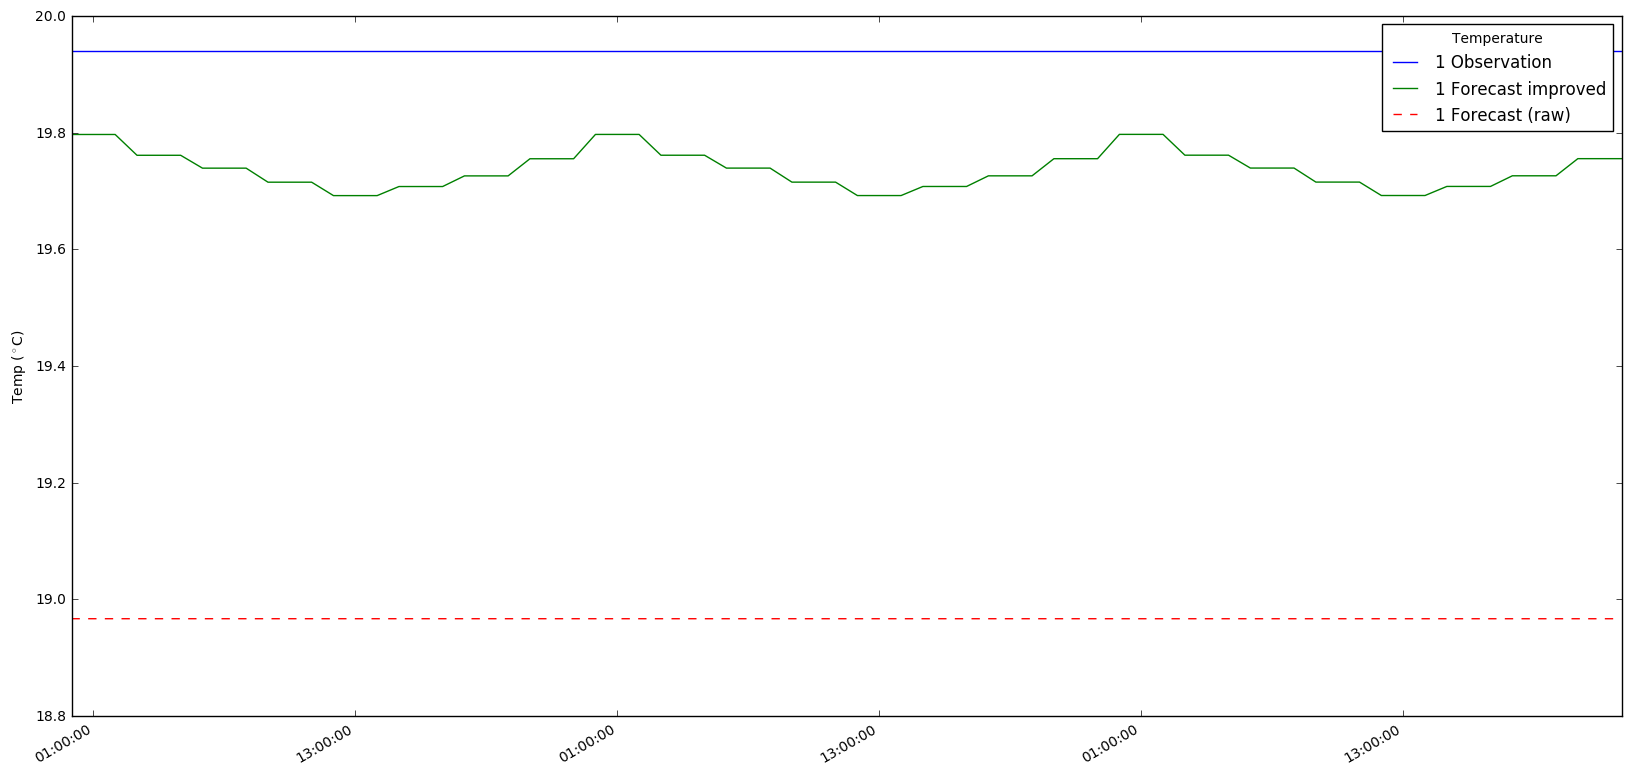

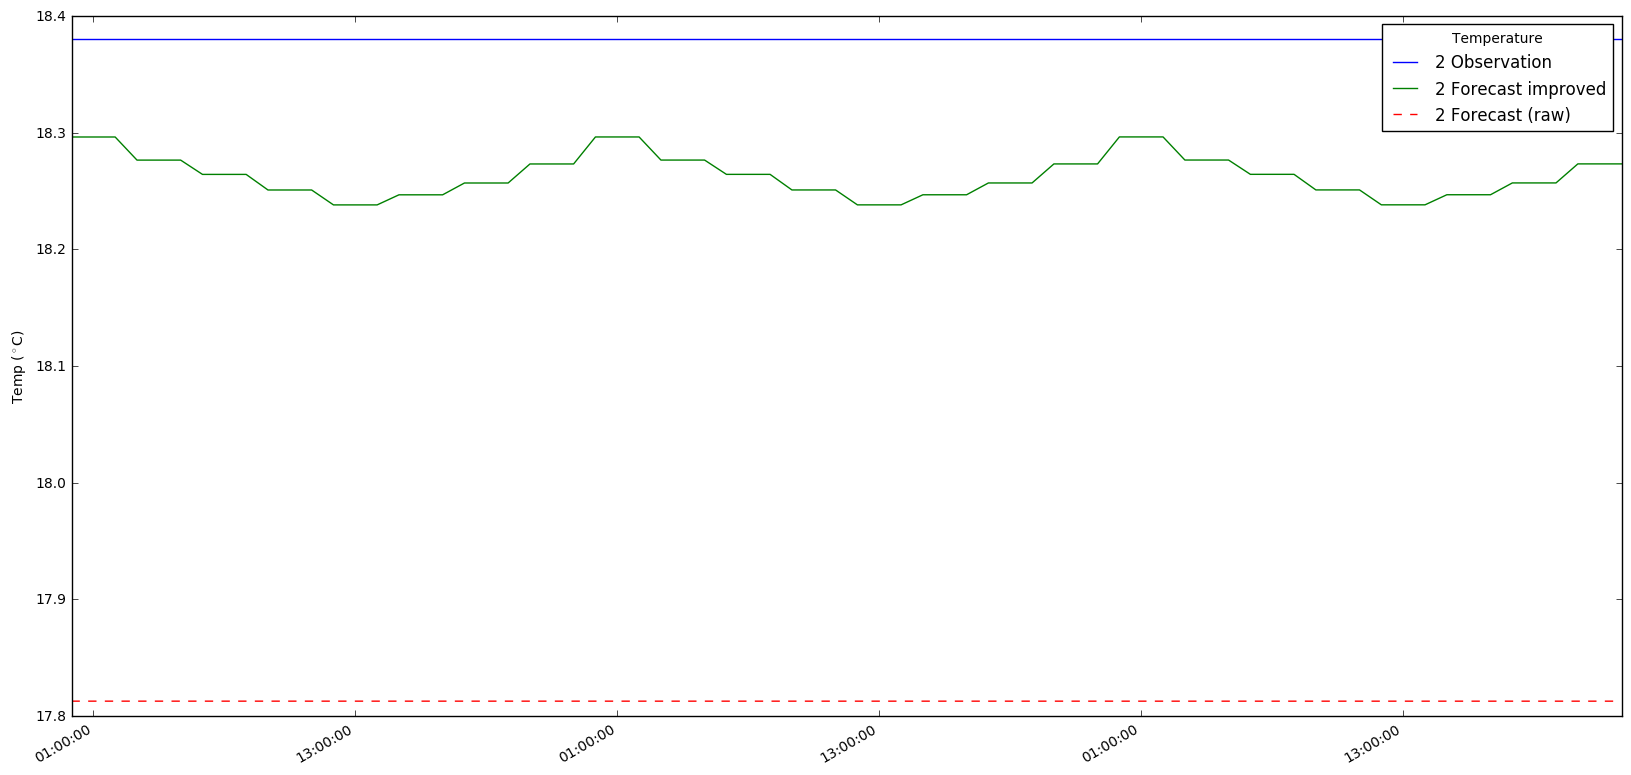

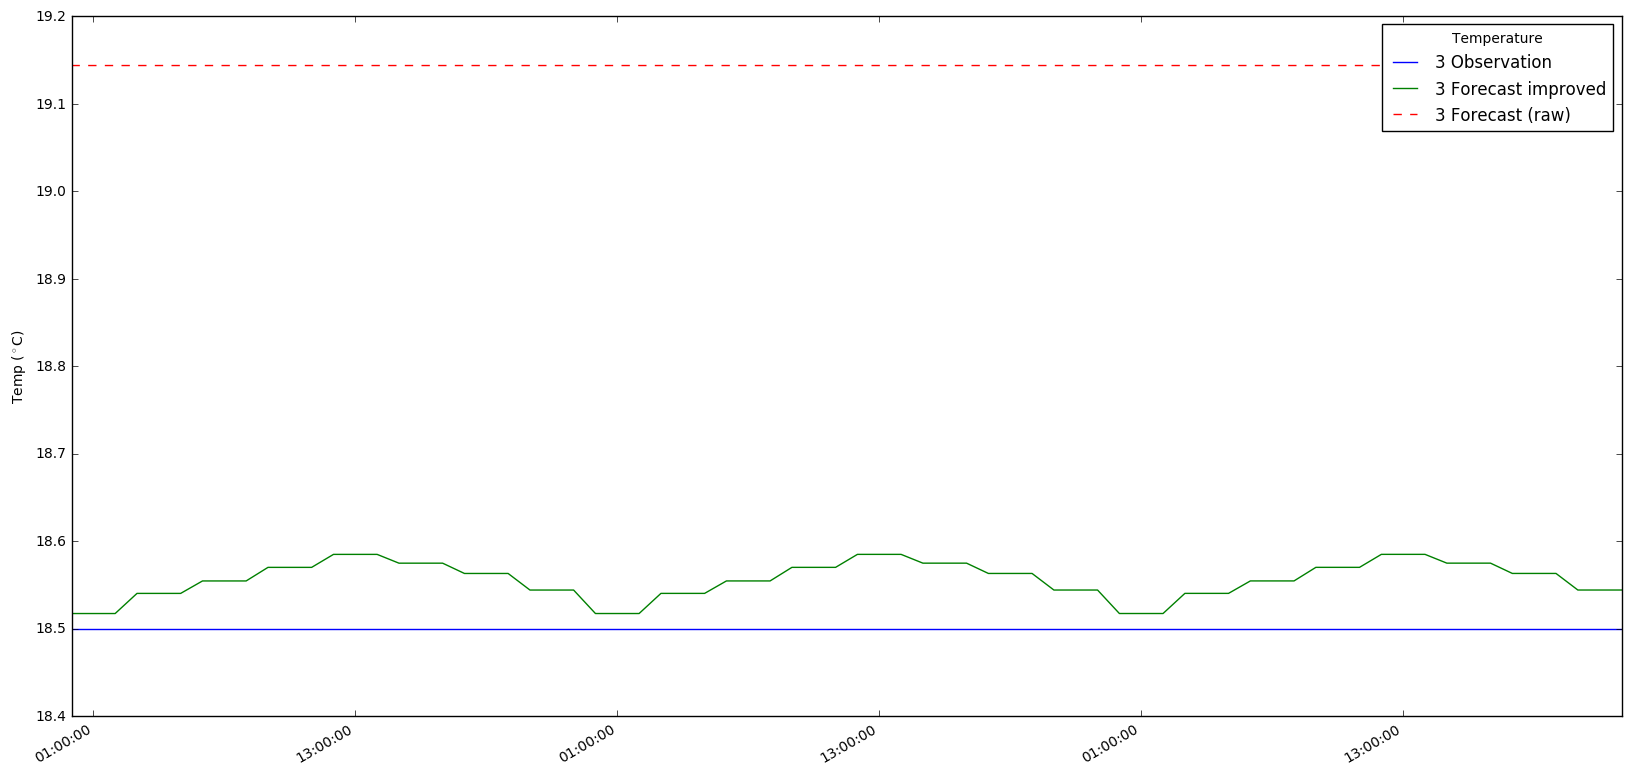

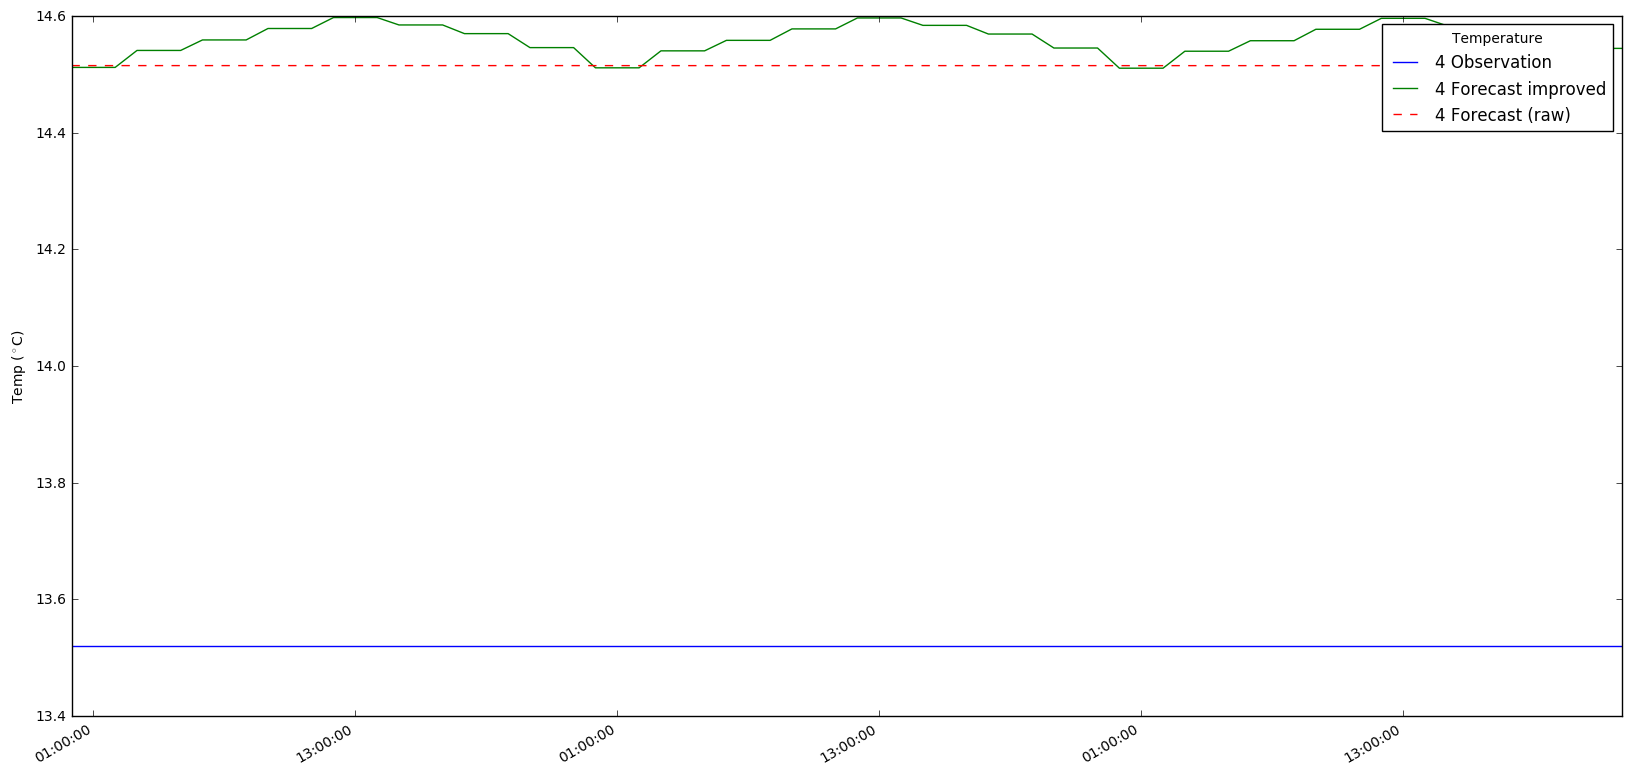

In [13]:
# Make a time-series plot of temperature sets
for i in range(len(bias_set)):
    fig, ax = plt.subplots(figsize=(20, 10))
    timestamps = [datetime.datetime.utcfromtimestamp(p.start) for p in obs_set[i].ts.time_axis]
    ax.plot(timestamps, obs_set[i].ts.values, label = str(i+1) + ' Observation')
    ax.plot(timestamps, fc_at_observations_improved[i].ts.values, label = str(i+1) + ' Forecast improved')
    ax.plot(timestamps, fc_at_observations_raw[i].ts.values,linestyle='--', label = str(i+1) + ' Forecast (raw)')
    #ax.plot(timestamps, bias_set[i].ts.values, label = str(i+1) + ' Bias')
    fig.autofmt_xdate()
    ax.legend(title='Temperature')
    ax.set_ylabel('Temp ($^\circ$C)')

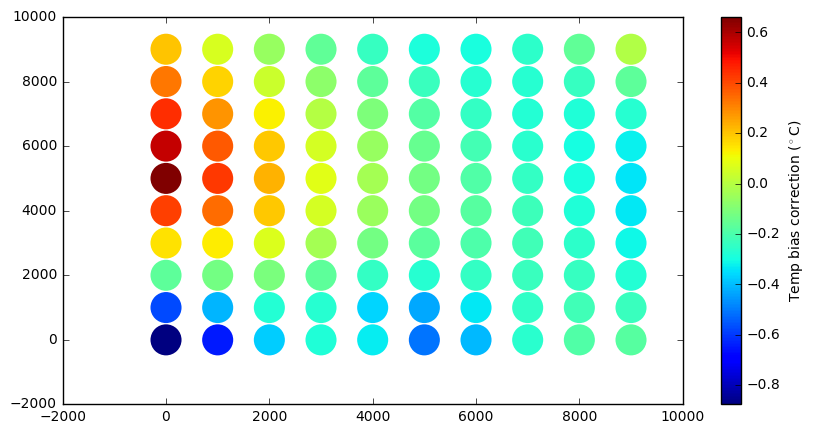

In [14]:
# Make a scatter plot of grid temperature forecasts at ts.value(0)
x = [fc.mid_point().x for fc in bias_grid]
y = [fc.mid_point().y for fc in bias_grid]
fig, ax = plt.subplots(figsize=(10, 5))
temps = np.array([bias.ts.value(0) for bias in bias_grid])
plot = ax.scatter(x, y, c=temps, marker='o', s=500, lw=0)
plt.colorbar(plot).set_label('Temp bias correction ($^\circ$C)')